In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
from PIL import Image
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models

from COCODataset import MaskedCOCODataset, COCODataset
from COCOWrapper import COCOWrapper
from ModelWrapper import ModelWrapper
from Train import train_model


In [3]:
model_choice = 1

root = '/home/gregory/Datasets/COCO/'
year = '2017'

run_train = True
n_trials = 10

In [4]:

if model_choice == 0:
    model = models.resnet18(pretrained = True)
    model.fc = torch.nn.Linear(in_features = 512, out_features = 91)
elif model_choice == 1:
    model = models.mobilenet_v2(pretrained = True)
    model.classifier[1] = torch.nn.Linear(in_features = 1280, out_features = 91)  
    
model.load_state_dict(torch.load('./model_transfer.pt'))
model.eval()
model.cuda()

wrapper = ModelWrapper(model) # Note:  the wrapper does not copy the model, so updating the model weights updates the wrapper

In [5]:

def my_dataloader(dataset):
    return torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True, num_workers = 4)

model_class = 'none'
labeler_classes = ['person']

altered_setup = 'box-True-default'
new_setups = ['box-True-random', 'pixel-True-random']

sources = {}
for mode in ['val', 'train']:
    sources[mode] = './DataAugmentation/{}{}-{}-{}/{}/'.format(mode, year, model_class, labeler_classes, altered_setup).replace("'", '').replace(" ", '')

# Unaltered Validation Set
dataset_original = COCODataset(root = root, mode = 'val', year = year)
dataloader_original = my_dataloader(dataset_original)

# Altered Validation Set
dataset_altered = MaskedCOCODataset('{}labels.p'.format(sources['val']))
dataloader_altered = my_dataloader(dataset_altered)

# Augmented Train/Validation Sets
cocos = {}
loaders = {}
datasets = {}

for mode in ['val', 'train']:

    base = '{}{}{}/'.format(root, mode, year)

    coco = COCOWrapper(root = root, mode = mode, year = year)
    cocos[mode] = coco

    datasets[mode] = COCODataset(root = root, mode = mode, year = year, sources = ['{}labels.p'.format(sources[mode])])

dataloaders = {mode: my_dataloader(datasets[mode]) for mode in ['val', 'train']}
dataset_sizes = {mode: len(datasets[mode]) for mode in ['val', 'train']}

# New Altered Validation set
datasets_new = {}
dataloaders_new = {}
for mode in new_setups:
    datasets_new[mode] = MaskedCOCODataset('{}labels.p'.format('./DataAugmentation/val{}-{}-{}/{}/'.format(year, model_class, labeler_classes, mode).replace("'", '').replace(" ", '')))
    dataloaders_new[mode] = my_dataloader(datasets_new[mode])




loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
loading annotations into memory...
Done (t=9.90s)
creating index...
index created!
loading annotations into memory...
Done (t=11.02s)
creating index...
index created!


In [6]:

save_location = './DataAugmentation-Models/{}-{}-{}/'.format(model_class, labeler_classes, altered_setup).replace("'", '').replace(" ", '')

if run_train:
    
    os.system('rm -rf {}'.format(save_location))
    Path(save_location).mkdir(parents=True, exist_ok=True)
    
     
    for i in range(n_trials):

        model.load_state_dict(torch.load('./model_transfer.pt'))

        model.train()

        for param in model.parameters():
            param.requires_grad = False

        if model_choice == 1:
            for param in model.classifier.parameters():
                param.requires_grad = True

            optim_params = model.classifier.parameters()


        criterion = torch.nn.BCEWithLogitsLoss()

        optimizer = optim.Adam(optim_params, lr = 0.001)

        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.1)

        model = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, exp_lr_scheduler, num_epochs = 1)

        torch.save(model.state_dict(), '{}model_{}.pt'.format(save_location, i))

        model.eval()
    


Epoch 0/0
----------
train Loss: 0.0747 Acc: 0.9680
val Loss: 0.0725 Acc: 0.9680

Training complete in 5m 54s
Best val Acc: 0.968023
Epoch 0/0
----------
train Loss: 0.0748 Acc: 0.9679
val Loss: 0.0722 Acc: 0.9682

Training complete in 6m 15s
Best val Acc: 0.968153
Epoch 0/0
----------
train Loss: 0.0748 Acc: 0.9680
val Loss: 0.0740 Acc: 0.9675

Training complete in 6m 11s
Best val Acc: 0.967503
Epoch 0/0
----------
train Loss: 0.0747 Acc: 0.9680
val Loss: 0.0720 Acc: 0.9683

Training complete in 6m 6s
Best val Acc: 0.968283
Epoch 0/0
----------
train Loss: 0.0748 Acc: 0.9679
val Loss: 0.0711 Acc: 0.9684

Training complete in 6m 6s
Best val Acc: 0.968413
Epoch 0/0
----------
train Loss: 0.0748 Acc: 0.9680
val Loss: 0.0725 Acc: 0.9684

Training complete in 6m 7s
Best val Acc: 0.968413
Epoch 0/0
----------
train Loss: 0.0747 Acc: 0.9679
val Loss: 0.0731 Acc: 0.9675

Training complete in 6m 6s
Best val Acc: 0.967503
Epoch 0/0
----------
train Loss: 0.0747 Acc: 0.9680
val Loss: 0.0729 Acc:

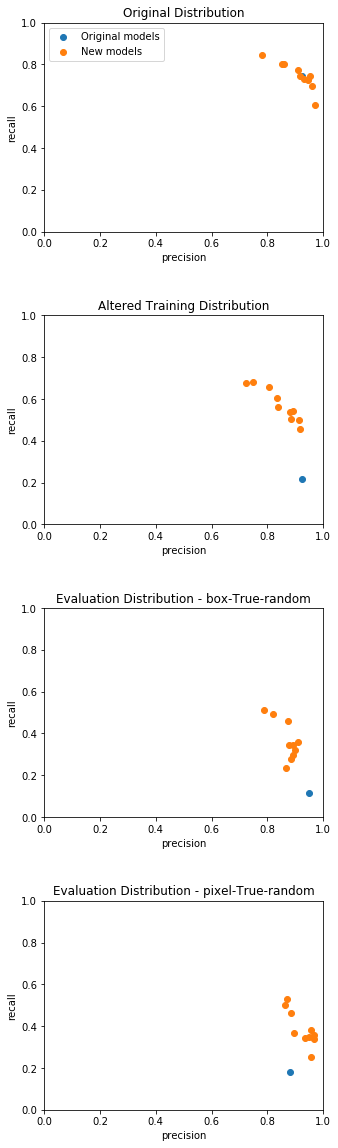

In [8]:
# Misc
plot_class = 'tennis racket'
index = cocos['val'].get_cat_ids(plot_class)[0]

original_models = ['./model_transfer.pt']
new_models = [ '{}model_{}.pt'.format(save_location, i) for i in range(n_trials)]

num = len(datasets_new) + 2

fig = plt.figure(figsize=(5, num * 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Original Validation Set

plt.subplot(num, 1, 1)
plt.title('Original Distribution')
plt.xlabel('precision')
plt.ylabel('recall')
plt.xlim([0, 1])
plt.ylim([0, 1])

p = []
r = []
for model_file in original_models:

    model.load_state_dict(torch.load(model_file))

    y_hat, y_true = wrapper.predict_dataset(dataloader_original)
    precision, recall = wrapper.metrics(y_hat, y_true)

    p.append(precision[index])
    r.append(recall[index])

plt.scatter(p, r, label = 'Original models')


p = []
r = []
for model_file in new_models:

    model.load_state_dict(torch.load(model_file))

    y_hat, y_true = wrapper.predict_dataset(dataloader_original)
    precision, recall = wrapper.metrics(y_hat, y_true)

    p.append(precision[index])
    r.append(recall[index])

plt.scatter(p, r, label = 'New models')
plt.legend()

# Altered Validation Set

plt.subplot(num, 1, 2)
plt.title('Altered Training Distribution')
plt.xlabel('precision')
plt.ylabel('recall')
plt.xlim([0, 1])
plt.ylim([0, 1])

p = []
r = []
for model_file in original_models:

    model.load_state_dict(torch.load(model_file))

    y_hat, y_true = wrapper.predict_dataset(dataloader_altered)
    precision, recall = wrapper.metrics(y_hat, y_true)

    p.append(precision[index])
    r.append(recall[index])

plt.scatter(p, r)


p = []
r = []
for model_file in new_models:

    model.load_state_dict(torch.load(model_file))

    y_hat, y_true = wrapper.predict_dataset(dataloader_altered)
    precision, recall = wrapper.metrics(y_hat, y_true)

    p.append(precision[index])
    r.append(recall[index])

plt.scatter(p, r)

c = 3
for mode in new_setups:

    plt.subplot(num, 1, c)
    plt.title('Evaluation Distribution - {}'.format(mode))
    plt.xlabel('precision')
    plt.ylabel('recall')
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    p = []
    r = []
    for model_file in original_models:

        model.load_state_dict(torch.load(model_file))

        y_hat, y_true = wrapper.predict_dataset(dataloaders_new[mode])
        precision, recall = wrapper.metrics(y_hat, y_true)

        p.append(precision[index])
        r.append(recall[index])

    plt.scatter(p, r)


    p = []
    r = []
    for model_file in new_models:

        model.load_state_dict(torch.load(model_file))

        y_hat, y_true = wrapper.predict_dataset(dataloaders_new[mode])
        precision, recall = wrapper.metrics(y_hat, y_true)

        p.append(precision[index])
        r.append(recall[index])

    plt.scatter(p, r)

    c += 1
    
plt.savefig('{}{}.png'.format(save_location, plot_class))

plt.show()
plt.close()

